In [ ]:
from reduced_ipca import ReducedPCA
from perturb_ipca import PerturbPCA
from utils import dict2numpy, vec2dict

## The code block

In [12]:
import numpy as np
from sklearn.decomposition import PCA

## Tests

### Sanity Check using gaussians 

In [19]:
test_data = np.random.normal(size=(10_000,10))*np.arange(10)
test_data = [{idx: i  for idx, i in enumerate(test_data[i])} for i in range(10_000)]
test_vec = {idx: i  for idx, i in enumerate(np.arange(10))} 
ipca = PerturbPCA(5)
for i in test_data:
    ipca.learn_one(i)
print(ipca.inverse_transform_one(ipca.transform_one(test_vec)))

{0: -1.5220333750582762e-14, 1: 0.017987819927709557, 2: -0.023448127234118512, 3: -0.14229812288750726, 4: 0.36512249765057225, 5: 5.142854143905582, 6: 5.978655288157072, 7: 6.983767508155171, 8: 7.990972774827598, 9: 9.03531975131827}


In [21]:
test_data = np.random.normal(size=(10_000,10))*np.arange(10)
test_data = [{idx: i  for idx, i in enumerate(test_data[i])} for i in range(10_000)]
test_vec = {idx: i  for idx, i in enumerate(np.arange(10))} 
ipca = ReducedPCA(5)
for i in test_data:
    ipca.learn_one(i)
print(ipca.inverse_transform_one(ipca.transform_one(test_vec)))


{0: 0.0, 1: 0.017256252156138702, 2: -0.052660702252332006, 3: 0.0723092066108676, 4: 0.1612006399716229, 5: 5.126887332938106, 6: 6.01108468294353, 7: 6.996122378734239, 8: 8.005064003537328, 9: 9.003505840092263}


### Visualising the IRIS dataset 

**We do IRIS dataset clustering using our Reduced PCA algorithm**

<class 'pandas.core.frame.DataFrame'>


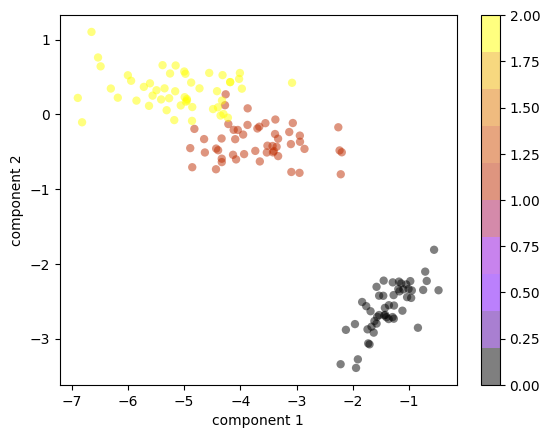

In [15]:
import matplotlib.pyplot as plt
from sklearn import datasets
from river.stream import iter_pandas
# unused but required import for doing 3d projections with matplotlib < 3.2

np.random.seed(5)

iris = datasets.load_iris(as_frame=True)
X = iris.data
print(type(X))
y = iris.target
stream = list(iter_pandas(X,y))
online_pca = ReducedPCA(2)
for (x,y) in stream:
    online_pca.learn_one(x)
    
results = np.array([dict2numpy(online_pca.transform_one(x)) for (x,y) in stream])
plt.scatter(results[:, 0], results[:, 1],
            c=iris.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('gnuplot', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

**We do IRIS dataset clustering using our PerturbPCA algorithm**

<class 'pandas.core.frame.DataFrame'>


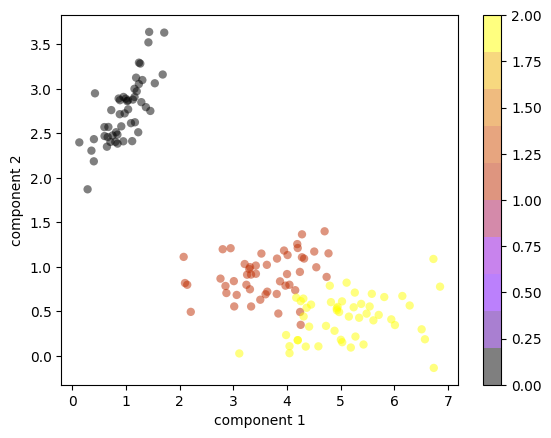

In [16]:
import matplotlib.pyplot as plt
from sklearn import datasets
from river.stream import iter_pandas
# unused but required import for doing 3d projections with matplotlib < 3.2

np.random.seed(5)

iris = datasets.load_iris(as_frame=True)
X = iris.data
print(type(X))
y = iris.target
stream = list(iter_pandas(X,y))
online_pca = PerturbPCA(2)
for (x,y) in stream:
    online_pca.learn_one(x)
    
results = np.array([dict2numpy(online_pca.transform_one(x)) for (x,y) in stream])
plt.scatter(results[:, 0], results[:, 1],
            c=iris.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('gnuplot', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

**We do IRIS dataset clustering using Sk-learn PCA algorithm**

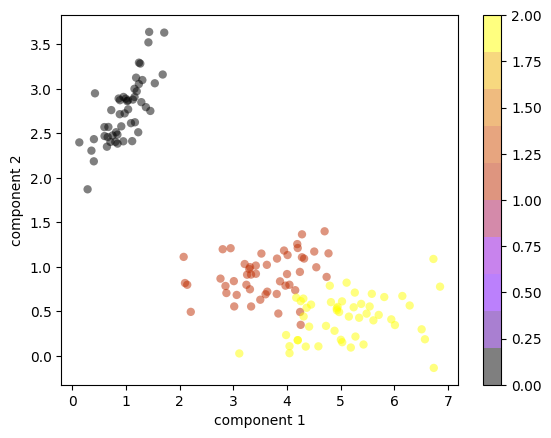

In [7]:

np.random.seed(5)

iris = datasets.load_iris(as_frame=True)
X = iris.data
y = iris.target
sk_pca = PCA(2)
sk_pca.fit(X)
results = sk_pca.transform(X)
    
results = np.array([dict2numpy(online_pca.transform_one(x)) for (x,y) in stream])
plt.scatter(results[:, 0], results[:, 1],
            c=iris.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('gnuplot', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### River intergration

In [ ]:
from river import linear_model
from river import metrics
import pandas as pd 
from river.stream import iter_pandas

def evaluate(stream, model, n_wait=100, verbose=True):
    def print_progress(sample_id, acc, kappa):
        print(f'Samples processed: {sample_id}')
        print(acc)
        print(kappa)

    acc = metrics.Accuracy()
    acc_rolling = metrics.Rolling(metric=metrics.Accuracy(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = metrics.Rolling(metric=metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    for i, (x, y) in enumerate(stream):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        acc_rolling.update(y_true=y, y_pred=y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        kappa_rolling.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, acc, kappa)
            raw_results.append([model_name, i, acc.get(), acc_rolling.get(), kappa.get(), kappa_rolling.get()])
        model.learn_one(x, y)
    print_progress(i, acc, kappa)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'acc_roll', 'kappa', 'kappa_roll'])


In [ ]:
from sklearn.datasets import fetch_covtype
data = fetch_covtype(as_frame=True)
X ,Y = data.data[:5_000], data.target[:5_000]
stream  = iter_pandas(X,Y)
pca = PerturbPCA(10)
lin = linear_model.SoftmaxRegression()
model = pca | lin
evaluate(stream=iter_pandas(X=X, y=Y),
                      model=model, n_wait=1000)

In [10]:
X ,Y = data.data[:5_000], data.target[:5_000]
stream  = iter_pandas(X,Y)
pca = ReducedPCA(10)
lin = linear_model.SoftmaxRegression()
model = pca | lin
evaluate(stream=iter_pandas(X=X, y=Y),
                      model=model, n_wait=1000)

Samples processed: 1000
Accuracy: 67.53%
CohenKappa: 43.46%
Samples processed: 2000
Accuracy: 70.61%
CohenKappa: 58.00%
Samples processed: 3000
Accuracy: 67.14%
CohenKappa: 58.49%
Samples processed: 4000
Accuracy: 68.53%
CohenKappa: 61.94%
Samples processed: 4999
Accuracy: 68.10%
CohenKappa: 61.40%


,model,id,acc,acc_roll,kappa,kappa_roll
0,Pipeline,1000,0.675325,0.676,0.434560,0.435085
1,Pipeline,2000,0.706147,0.737,0.580027,0.650427
2,Pipeline,3000,0.671443,0.602,0.584936,0.500694
3,Pipeline,4000,0.685329,0.727,0.619374,0.552632
